## Exploratory Data Analysis

### Imports and definitions

In [139]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import sklearn
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import albumentations
import albumentations.pytorch
import torchvision
import tqdm
import torchvision.transforms.v2 as transforms

#### Random seeds for reproducibility

In [140]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
sklearn.random.seed(0)

#### Constants

In [141]:
IMAGE_SIZE = (224, 224)

#### Download the dataset

To run this, it's needed to have kaggle.json from a kaggle key in ~/.kaggle folder

Alternatively, skip this part and manually download the dataset https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection in ./data folder

In [142]:
import kaggle

os.makedirs("data", exist_ok=True)

kaggle.api.authenticate()

kaggle.api.dataset_download_files(
    "volodymyrpivoshenko/brain-mri-scan-images-tumor-detection", path="data", unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/volodymyrpivoshenko/brain-mri-scan-images-tumor-detection


### Loading images

In [143]:
def load_imgs(data_root_folder="data"):
    images = []
    labels = []

    data_folder = os.path.join(data_root_folder, "brain_mri_scan_images")

    pos_folder = os.path.join(data_folder, "positive")
    neg_folder = os.path.join(data_folder, "negative")

    for img_name in os.listdir(pos_folder):
        img = cv2.imread(os.path.join(pos_folder, img_name))
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(1)

    for img_name in os.listdir(neg_folder):
        img = cv2.imread(os.path.join(neg_folder, img_name))
        img = cv2.resize(img, IMAGE_SIZE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(0)

    return np.array(images), np.array(labels)

In [144]:
images, labels = load_imgs()

#### Visualizing images of each class

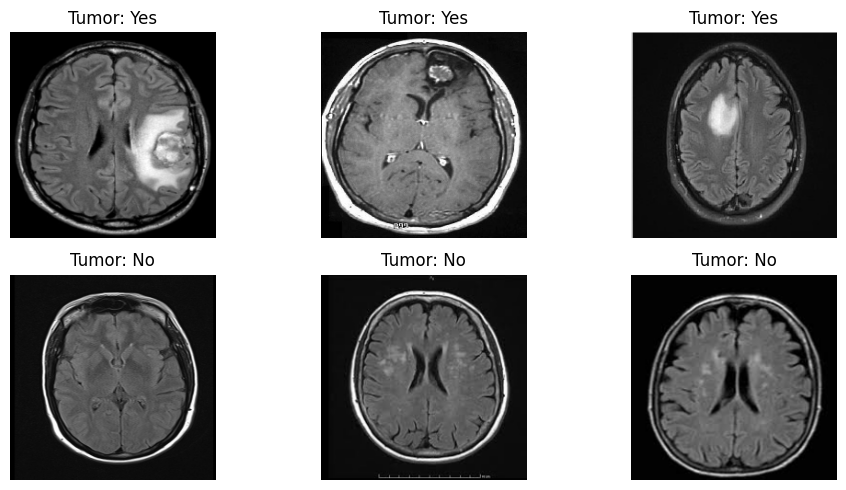

In [145]:
plt.figure(figsize=(10, 5))

for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[labels == 1][i + 10])
    plt.title("Tumor: Yes")
    plt.axis("off")

for i in range(3):
    plt.subplot(2, 3, i + 4)
    plt.imshow(images[labels == 0][i + 10])
    plt.title("Tumor: No")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Visualizing class distribution

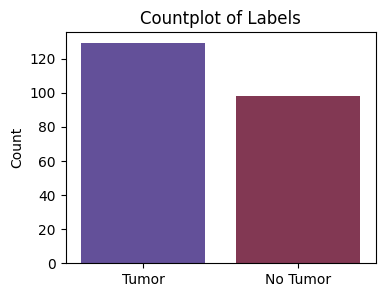

In [146]:
labels_nominal = np.where(labels == 0, "No Tumor", "Tumor")
plt.figure(figsize=(4, 3))
sns.countplot(x=labels_nominal, hue=labels_nominal, palette="twilight")
plt.title("Countplot of Labels")
plt.ylabel("Count")
plt.show()

### Data pre-processing

#### Custom transformation to crop only the brain region

In [164]:
class CropBrainRegion(albumentations.core.transforms_interface.ImageOnlyTransform):
    def __init__(
        self, output_size=IMAGE_SIZE, always_apply=False, p=1.0, return_everything=False
    ):
        super(CropBrainRegion, self).__init__(always_apply, p)
        self.size = output_size
        self.return_everything = return_everything

    def apply(self, image, **params):
        # Converting the image to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Applying Gaussian blur to smooth the image and reduce noise
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # Thresholding the image to create a binary mask
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

        # Performing morphological operations to remove noise
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # Finding contours in the binary mask
        contours, _ = cv2.findContours(
            thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Assuming the brain part of the image has the largest contour
        c = max(contours, key=cv2.contourArea)

        # Getting the bounding rectangle of the brain part
        x, y, w, h = cv2.boundingRect(c)

        if self.return_everything:
            # Drawing contours on the original image
            contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)

            # Drawing bounding box on the original image
            bounding_box_image = cv2.rectangle(
                image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2
            )

        # Cropping the image around the bounding rectangle
        cropped_image = image[y : y + h, x : x + w]

        # Resizing cropped image to the needed size
        resized_image = cv2.resize(cropped_image, self.size)

        if self.return_everything:
            return resized_image, contour_image, bounding_box_image, cropped_image
        else:
            return resized_image

    def get_transform_init_args_names(self):
        return ("size",)

##### Visually checking the brain region crop transformation

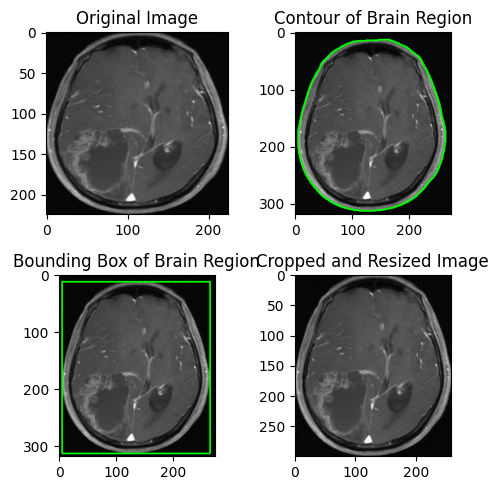

In [176]:
example_image = cv2.imread("data/brain_mri_scan_images/positive/1.jpg")
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

example_image, contour_image, bounding_box_image, resized_image = CropBrainRegion(
    output_size=IMAGE_SIZE, return_everything=True
)(image=example_image)["image"]

plt.figure(figsize=(5, 5))

plt.subplot(2, 2, 1)
plt.imshow(example_image)
plt.title("Original Image")

plt.subplot(2, 2, 2)
plt.imshow(contour_image)
plt.title("Contour of Brain Region")

plt.subplot(2, 2, 3)
plt.imshow(bounding_box_image)
plt.title("Bounding Box of Brain Region")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Cropped and Resized Image")

plt.tight_layout()
plt.show()

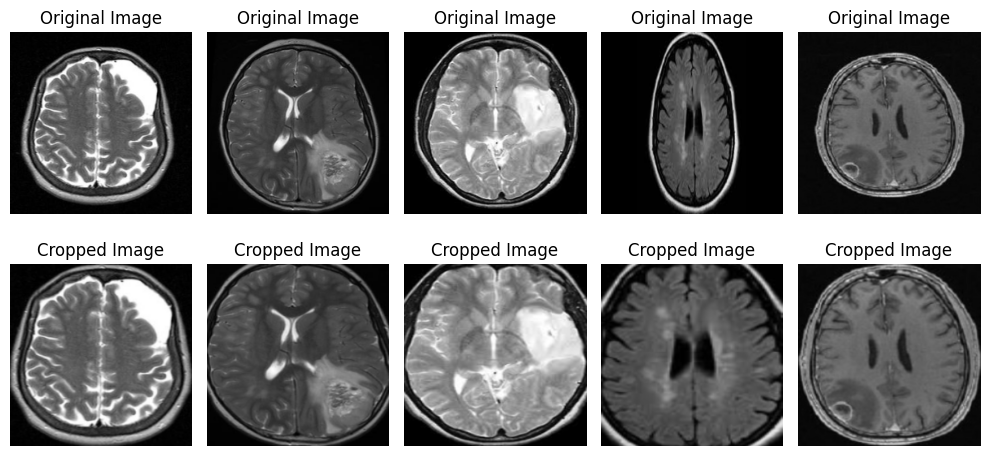

In [156]:
crop_transform = CropBrainRegion(output_size=IMAGE_SIZE)

imgs_to_show = np.concatenate(
    (images[labels == 1][15:18], images[labels == 0][15:17]), axis=0
)
cropped_imgs = [crop_transform(image=img)["image"] for img in imgs_to_show]

plt.figure(figsize=(10, 5))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs_to_show[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(cropped_imgs[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Defining transformations and augmentations

In [157]:
test_transform = albumentations.Compose(
    [
        CropBrainRegion(output_size=IMAGE_SIZE),
        albumentations.Normalize(),
        albumentations.pytorch.ToTensorV2(),
    ]
)

train_transform = albumentations.Compose(
    [
        CropBrainRegion(output_size=IMAGE_SIZE),
        albumentations.Rotate(limit=20, p=0.5),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.5
        ),
        albumentations.Normalize(),
        albumentations.pytorch.ToTensorV2(),
    ]
)

#### Data splitting

In [158]:
train_images, remaining_images, train_labels, remaining_labels = (
    sklearn.model_selection.train_test_split(
        images, labels, test_size=0.2, random_state=0
    )
)

val_images, test_images, val_labels, test_labels = (
    sklearn.model_selection.train_test_split(
        remaining_images, remaining_labels, test_size=0.5, random_state=0
    )
)

print("Train dataset size:", len(train_images))
print("Validation dataset size:", len(val_images))
print("Test dataset size:", len(test_images))

Train dataset size: 181
Validation dataset size: 23
Test dataset size: 23


#### Defining the dataset

In [159]:
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

In [160]:
train_dataset = BrainTumorDataset(train_images, train_labels, transform=train_transform)
val_dataset = BrainTumorDataset(val_images, val_labels, transform=test_transform)
test_dataset = BrainTumorDataset(test_images, test_labels, transform=test_transform)

batch_size = 16
num_workers = 2

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
)